In [1]:
import tensorflow as tf
import edward as ed
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
np.random.seed(1234)

Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
sess = tf.InteractiveSession()

In [3]:
floatX='float32'

In [4]:
data = pd.read_csv('./data/test_rus_data.csv').values.astype(floatX).T[np.newaxis][:,2:]/100
# data = data[:,1:]-data[:,:-1]

In [5]:
data.shape

(1, 20, 3)

In [6]:
stds = (data[0,1:] - data[0,:-1]).std(axis=0)
print(stds)
data /= stds

[0.2174228  0.16835931 0.01139835]


In [7]:
xs = data

In [8]:
xs.shape

(1, 20, 3)

In [9]:
n = data.shape[1]
s1 = 0.01
s0 = np.sqrt(2.**2 - s1**2)
dim = [3,4]
T = 50000

k = dim[0] * dim[1]

t = tf.Variable(0, name='step')

pikes = tf.Variable(np.zeros([T,n], dtype='bool'), name='pikes')

mean = float(np.log(0.2))
std = 0.015
c = np.ones(n, dtype=floatX)-1+mean
r = np.ones_like(c)*std
low_scale = ed.models.Normal(loc=c, scale=r)#Gamma(concentration=c, rate=r)

mean = float(np.log(0.2))
std = 0.025
c = mean
r = std
incr = ed.models.Normal(loc=c, scale=r)
high_scale = tf.exp(low_scale)*(tf.exp(incr)+1)

cpikes = tf.gather(pikes, tf.maximum(t-1,0))
scale = tf.where(cpikes, high_scale, tf.exp(low_scale))

PWalk = ed.models.Normal(loc=np.zeros([n,k], dtype=floatX), scale=scale[:,tf.newaxis])
PInit = ed.models.Normal(loc=0., scale=[s0]*k)

tmp = tf.reshape(PWalk, [n, k])
outs = [PInit]
for i in range(n):
    ap = outs[-1] + tmp[i]
    outs.append(ap)
outs = outs[1:]
Walk = tf.stack(outs)

In [10]:
def autoregr_tf(X, param):
    d = param[:,:dim[-1]-1]
    X = tf.matmul(X, d) + param[:,-1][np.newaxis]
    return X

In [11]:
outputs = tf.reshape(Walk, [1, n, dim[0]*dim[1]])

In [12]:
def get_preds():
    out = tf.reshape(outputs, [n, dim[0], dim[1]])
    
    def step1(current):
        X = current[0][np.newaxis]
        param = current[1]
        d = param[:,:dim[-1]-1]
        X = tf.matmul(X, d)[0] + param[:,-1]
        return X
    ret = []
    for i in range(n-1):
        current = xs[0][i], out[i]
        ret.append(step1(current))
    return tf.stack(ret)

In [13]:
preds = get_preds()

In [14]:
preds

<tf.Tensor 'stack_1:0' shape=(19, 3) dtype=float32>

In [15]:
y = ed.models.Normal(loc=preds, scale=1.)

In [16]:
low_scale_q = ed.models.Empirical(tf.get_variable('low_scale_q', initializer=tf.zeros([T,n])+0.01))
incr_q = ed.models.Empirical(tf.get_variable('incr_q', initializer=tf.zeros([T])+0.01))
PWalk_q = ed.models.Empirical(tf.get_variable('PWalk_q', initializer=tf.zeros([T,n,dim[0]*dim[1]])))
PInit_q = ed.models.Empirical(tf.get_variable('PInit_q', initializer=tf.zeros([T,dim[0]*dim[1]])))

In [17]:
subs = {PWalk:PWalk_q, PInit:PInit_q, low_scale:low_scale_q, incr: incr_q}
inference = ed.HMC(subs, data={y:xs[0,1:]})

/home/nikita/.virtualenvs/py3.6/lib/python3.6/site-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


In [18]:
extr = lambda t, x: list(map(lambda x: tf.gather(x.get_variables()[0], t), x))
vsq = [PWalk_q, PInit_q, low_scale_q, incr_q]
vs = [PWalk, PInit, low_scale, incr]
eval_points = extr(t, vsq)
lps = [tf.reduce_sum(x.log_prob(y)) for x,y in zip(vs, eval_points)]
logprob = tf.reduce_sum(lps)

In [19]:
pike_inp = tf.placeholder(tf.bool, [n])
logprob_eval = ed.copy(logprob, {cpikes:pike_inp})

In [20]:
def get_pks(n,k):
    if k==0:
        return [[0]*n]
    if n==1:
        if k == 1:
            return [[1]]
        elif k==0:
            return [[0]]
        else:
            raise ValueError
    
    ret = []
    ret += [[1] + x for x in get_pks(n-1, k-1)]
    if n > k:
        ret += [[0] + x for x in get_pks(n-1,k)]
    return ret

all_pks = get_pks(n, 3)
print(len(all_pks))
def sample_pikes():
    evl = lambda pike: sess.run(logprob_eval, {pike_inp:pike})
    probs = [evl(x) for x in all_pks]
    probs = np.array(probs)
    probs -= probs.mean()
    probs = np.exp(np.array(probs)).astype('float64')
    probs /= probs.sum()
    if np.any(np.isnan(probs)):
        raise ValueError
    smp = np.random.choice(range(len(all_pks)), p=probs)
    return np.array(all_pks[smp]).astype('bool')

1140


In [21]:
inference.initialize(step_size=1e-2,n_steps=20)
tf.global_variables_initializer().run()

In [22]:
pikes_upd = tf.scatter_update(pikes, t, pike_inp)
upd_op = t.assign_add(1)

In [23]:
i=0

In [24]:
for i in range(i,inference.n_iter):
    res = inference.update()
    new_pike = sample_pikes()
    if i != inference.n_iter -1:
        sess.run(pikes_upd, {pike_inp:new_pike})
        sess.run(upd_op)
    inference.print_progress(res)

50000/50000 [100%] ██████████████████████████████ Elapsed: 12472s | Acceptance Rate: 0.781


In [25]:
# i = 2
# logprob_eval = ed.copy(tf.reduce_sum(vs[i].log_prob(eval_points[i])), {cpikes:pike_inp})

In [25]:
vs

[<ed.RandomVariable 'Normal_2/' shape=(20, 12) dtype=float32>,
 <ed.RandomVariable 'Normal_3/' shape=(12,) dtype=float32>,
 <ed.RandomVariable 'Normal/' shape=(20,) dtype=float32>,
 <ed.RandomVariable 'Normal_1/' shape=() dtype=float32>]

In [26]:
evl = lambda pike: sess.run(logprob_eval, {pike_inp:pike})

In [27]:
evl(all_pks[2])

91.4899

In [28]:
# sess.run(t.assign(20))

In [26]:
out = tf.reshape(ed.copy(outputs, {PWalk:PWalk_q, PInit:PInit_q}), [n, dim[0], dim[1]])

In [27]:
samples=[]
for _ in range(3000):
    samples.append(out.eval())
samples = np.array(samples)

In [28]:
# def burnin(*emps):
#     return map(ed.models.Empirical, [x.get_variables()[0][2000:] for x in emps])

In [29]:
# PWalk_q, PInit_q = burnin(PWalk_q, PInit_q)

In [30]:
samples.shape

(3000, 20, 3, 4)

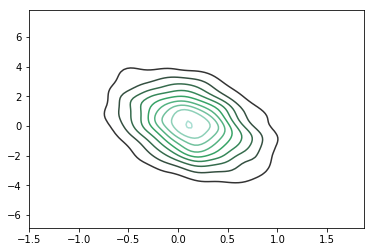

In [31]:
sns.kdeplot(samples[:,0,2,0], samples[:,11,0,3])
plt.show()

In [32]:
pp = pikes.eval().mean(axis=0)

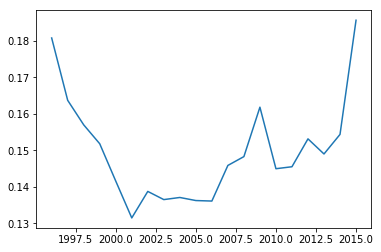

In [33]:
x = range(1996,2016)
plt.plot(x,pp)
plt.show()

In [37]:
samples.mean(axis=0)[10]

array([[-0.4293576 , -0.00101855, -0.23306388,  0.04272224],
       [ 0.27944702, -0.331215  ,  0.00592506, -0.06579777],
       [ 0.14394076, -0.2612748 ,  0.14227562, -0.13728476]],
      dtype=float32)

In [38]:
high_scale_q = ed.copy(high_scale, {low_scale:low_scale_q, incr: incr_q})

In [48]:
samples = []
for _ in range(3000):
    s = sess.run([low_scale_q, high_scale_q])
    s[0] = np.exp(s[0])
    samples.append(s)
samples=np.array(samples)

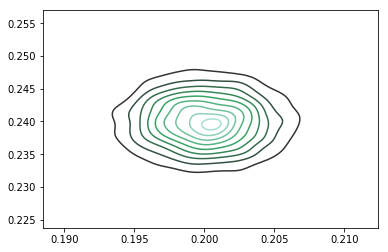

In [50]:
sns.kdeplot(samples[:,0,10], samples[:,1,10])
plt.show()

In [46]:
samples.shape

(3000, 2, 19)